# Noised SynthSeg
env: python3.8 tensorflow

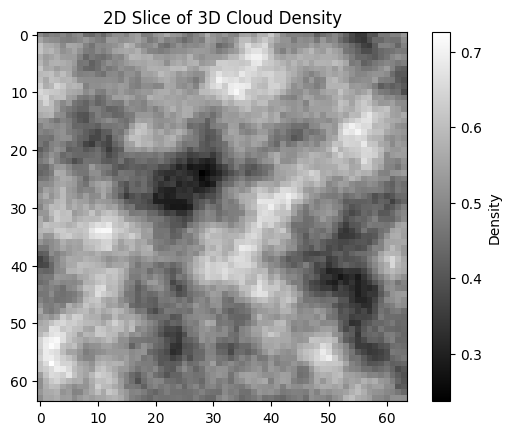

Density array shape: (64, 64, 64)
Max density: 0.7691708207130432
Min density: 0.21027830243110657


In [22]:
import numpy as np
import noise  # For Perlin Noise
import matplotlib.pyplot as plt  # For visualization (optional)

# Parameters
grid_size = 64  # Size of the 3D grid (e.g., 64x64x64)
scale = 4.0    # Noise scale (larger values = smoother clouds)
octaves = 6     # Number of noise layers
persistence = 0.5  # Amplitude reduction per octave
lacunarity = 3   # Frequency increase per octave
threshold = 0.01    # Density threshold for cloud presence

# Create a 3D grid of coordinates
x = np.linspace(0, scale, grid_size)
y = np.linspace(0, scale, grid_size)
z = np.linspace(0, scale, grid_size)
X, Y, Z = np.meshgrid(x, y, z)  # 3D coordinate arrays

# Initialize the density array
density = np.zeros((grid_size, grid_size, grid_size))

# Generate Perlin Noise with octaves
for i in range(grid_size):
    for j in range(grid_size):
        for k in range(grid_size):
            # Base noise value at this position
            value = noise.pnoise3(
                X[i, j, k], Y[i, j, k], Z[i, j, k],
                octaves=octaves,
                persistence=persistence,
                lacunarity=lacunarity,
                repeatx=grid_size,
                repeaty=grid_size,
                repeatz=grid_size,
                base=42  # Seed for reproducibility
            )
            # Normalize noise from [-1, 1] to [0, 1]
            value = (value + 1) / 2
            density[i, j, k] = value

# Apply threshold to define cloud boundaries
density = np.where(density > threshold, density, 0)

# Optional: Visualize a 2D slice of the 3D density field
slice_2d = density[:, :, grid_size // 2]  # Take a middle slice along Z-axis
plt.imshow(slice_2d, cmap='gray')
plt.title("2D Slice of 3D Cloud Density")
plt.colorbar(label="Density")
plt.show()

# The `density` array now contains the 3D cloud data
print("Density array shape:", density.shape)
print("Max density:", np.max(density))
print("Min density:", np.min(density))

In [12]:
from utils.check_image import check_image

check_image(
    [
        {"image": density, "title": "image", "is_label": False},
    ]
)

interactive(children=(IntSlider(value=0, description='slice_index_0', max=63), Output()), _dom_classes=('widge…

In [1]:
# import and constant
import os
import numpy as np
import nibabel as nib
from utils.nrrd2nii import nrrd2nii

source_path = "data/uwa_aaa"
combined_path = "data/uwa_aaa_combined"
# generation
image_path = "data/Dataset001_aaa/imagesTr"
label_path = "data/Dataset001_aaa/labelsTr"


# Generation Preprocess

In [25]:

os.makedirs(combined_path, exist_ok=True)

for patient_folder in sorted(os.listdir(source_path))[:5]:
    patient_path = os.path.join(source_path, patient_folder)
    aaa_label = None
    blood_label = None
    for root, dirs, files in os.walk(patient_path):
        for file in files:
            if file == "CT_AAA_label.nrrd":
                aaa_label = nrrd2nii(os.path.join(root, file)).get_fdata()
                assert (
                    len(np.unique(aaa_label)) == 2
                ), f"Patient {patient_folder} label error"
                highest_label = np.max(aaa_label)
                aaa_label[aaa_label == highest_label] = 1

            if file == "CT_blood_label.nrrd":
                blood_label = nrrd2nii(os.path.join(root, file)).get_fdata()
                assert (
                    len(np.unique(blood_label)) == 2
                ), f"Patient {patient_folder} label error"
                highest_label = np.max(blood_label)
                blood_label[blood_label == highest_label] = 1

    assert (aaa_label is not None) and (
        blood_label is not None
    ), f"Patient {patient_folder} label uncompleted"

    combined_label = np.zeros_like(aaa_label)
    combined_label[aaa_label == 1] = 1
    combined_label[blood_label == 1] = 2
    
    # if shape contains singular, make it even
    padding = []
    for dim in combined_label.shape:
        if dim % 2 == 1:
            padding.append(1)
        else:
            padding.append(0)
    combined_label = np.pad(
        combined_label,
        ((0, padding[0]), (0, padding[1]), (0, padding[2])),
        mode="constant",
    )
    
    label_nii = nib.Nifti1Image(combined_label, np.eye(4))
    nib.save(label_nii, os.path.join(combined_path, f"{patient_folder}_combined.nii.gz"))

# Generation

In [2]:
import sys
import os
from SynthSegAAA.brain_generator import BrainGenerator
# mkdir
os.makedirs(image_path, exist_ok=True)
os.makedirs(label_path, exist_ok=True)
label_files = os.listdir(combined_path)
count = 0
for label_file in label_files:
    print("here", os.path.join(combined_path, label_file))
    brain_generator = BrainGenerator(os.path.join(combined_path, label_file))
    for i in range(10):
        image, label = brain_generator.generate_brain()
        nib.save(
            nib.Nifti1Image(image, np.eye(4)),
            os.path.join(image_path, f"aaa_{count:03d}_0000.nii.gz"),
        )
        nib.save(
            nib.Nifti1Image(label, np.eye(4)),
            os.path.join(label_path, f"aaa_{count:03d}.nii.gz"),
        )
        count += 1

Using TensorFlow backend.


here data/uwa_aaa_combined/Patient13_combined.nii.gz
Compiling list of unique labels
processing 1/1


2025-03-31 14:59:46.367927: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-03-31 14:59:46.543556: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-31 14:59:46.543595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 46 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2025-03-31 14:59:46.544044: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2025-03-31 14:59:46.544106: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic 

here data/uwa_aaa_combined/Patient11_combined.nii.gz
Compiling list of unique labels
processing 1/1
here data/uwa_aaa_combined/Patient10_combined.nii.gz
Compiling list of unique labels
processing 1/1
here data/uwa_aaa_combined/Patient12_combined.nii.gz
Compiling list of unique labels
processing 1/1
here data/uwa_aaa_combined/Patient1_combined.nii.gz
Compiling list of unique labels
processing 1/1


# Inspection

In [2]:

from utils.check_image import check_image
import nibabel as nib
from utils.nrrd2nii import nrrd2nii


label = nib.load("data/uwa_aaa_combined/Patient1_combined.nii.gz").get_fdata()
image = nrrd2nii("data/uwa_aaa/Patient1/Segmentation/CT_cropped.nrrd").get_fdata()

check_image(
    [
        {"image": label, "title": "label", "is_label": True},
        {"image": image, "title": "image", "is_label": False},
    ]
)

interactive(children=(IntSlider(value=0, description='slice_index_0', max=125), IntSlider(value=0, description…

In [3]:

from utils.check_image import check_image
import nibabel as nib
from utils.nrrd2nii import nrrd2nii


label = nib.load("data/Dataset001_aaa/labelsTr/aaa_000.nii.gz").get_fdata()
image = nib.load("data/Dataset001_aaa/imagesTr/aaa_000_0000.nii.gz").get_fdata()

check_image(
    [
        {"image": label, "title": "label", "is_label": True},
        {"image": image, "title": "image", "is_label": False},
    ]
)

interactive(children=(IntSlider(value=0, description='slice_index_0', max=279), IntSlider(value=0, description…